In [1]:
import sys
sys.path.insert(0, '../pyLDLE2/')

In [2]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf
from matplotlib import pyplot as plt

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [3]:
vis = visualize_.Visualize()

In [4]:
X, labelsMat, ddX = datasets.Datasets().circular_disk(RES=50)

X.shape =  (7825, 2)


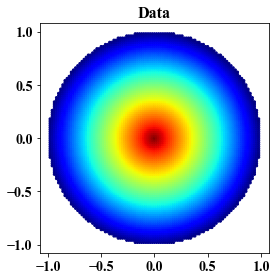

In [5]:
vis.data(X, ddX)

In [6]:
k_nn = 49
neigh_dist, neigh_ind = util_.nearest_neighbors(X, k_nn, metric='euclidean')

In [7]:
h = 0.05
K = np.exp(-neigh_dist**2/h**2)

In [8]:
n = X.shape[0]
source_ind = np.repeat(np.arange(n),neigh_ind.shape[1])
K = coo_matrix((K.flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))
ones_K_like = coo_matrix((np.ones(neigh_dist.shape).flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))

# symmetrize
K = K + K.T
ones_K_like = ones_K_like + ones_K_like.T
K.data /= ones_K_like.data

In [9]:
K = K.tocoo()

In [10]:
def sinkhorn(K, maxiter=5000, delta=1e-10, eps=1e-20):
    """https://epubs.siam.org/doi/pdf/10.1137/20M1342124 """
    D = np.array(K.sum(axis=1)).squeeze()
    d0 = 1./(D + eps)
    dp = 1./(K.dot(d0) + eps)
    d = 1./(K.dot(dp) + eps)
    tau = 2
    for tau in range(maxiter):
        d = 1. / (K.T.dot(dp) + eps)
        dr = np.sqrt(dp * d)
        if np.max(np.abs(dp / d - 1)) < delta:
            print('Converged at iter:', tau)
            break
        dp = d
    K.data = K.data*dr[K.row]*dr[K.col]
    return K, d

K, D = sinkhorn(K)
K = K.tocsr()

In [11]:
mu_hN_norm = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    temp = X-X[i,:][None,:]
    mu_hN_norm[i] = np.linalg.norm(K.getrow(i).dot(temp))

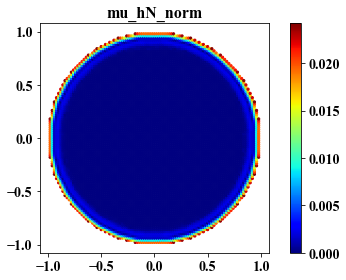

In [12]:
vis.data(X, mu_hN_norm, title='mu_hN_norm', colorbar=True)

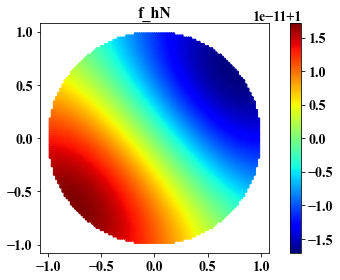

In [13]:
vis.data(X, np.array(K.sum(axis=1)).flatten(), title='f_hN', colorbar=True)

In [14]:
c_num = h*np.array(K.sum(axis=1)).flatten()/np.sqrt(np.pi)
c_denom = mu_hN_norm
c = c_num/(c_denom+1e-20)

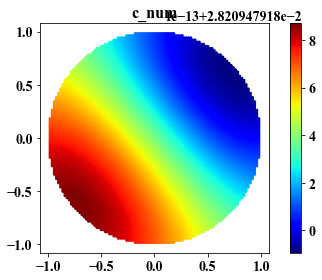

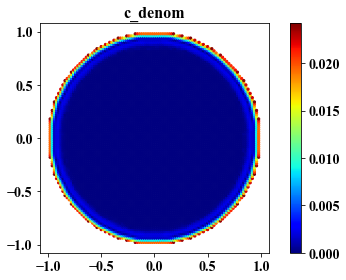

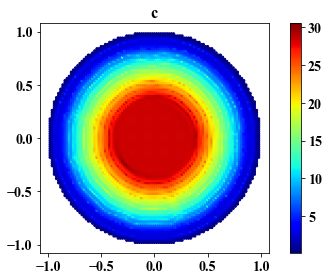

In [15]:
vis.data(X, c_num, title='c_num', colorbar=True)
vis.data(X, c_denom, title='c_denom', colorbar=True)
vis.data(X, np.log(c), title='c', colorbar=True)

In [16]:
def F(x):
    return c_denom*(1+erf(x/h))*np.exp(x**2/h**2)-c_num

def F_prime(x):
    return (c_denom/h)*(2/np.sqrt(np.pi) + 2*(1+erf(x/h))*np.exp(x**2/h**2)*x/h)

In [17]:
bx_init = h*np.sqrt(np.maximum(0, -np.log(2*c_denom+1e-30)+np.log(c_num+1e-30)))

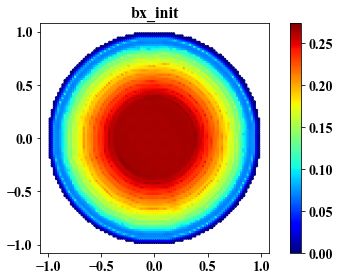

In [18]:
vis.data(X[:,:2], bx_init, title='bx_init', colorbar=True)

In [19]:
bx = optimize.newton(F, bx_init, F_prime, maxiter=50)

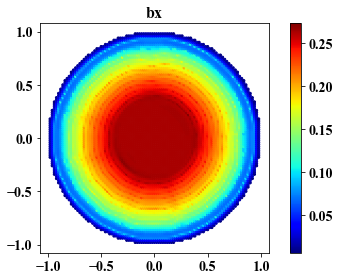

In [20]:
vis.data(X[:,:2], bx, title='bx', colorbar=True)

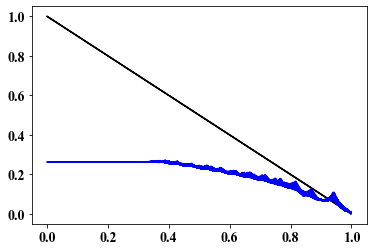

In [21]:
plt.plot(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.plot(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')